In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from itertools import product

from sklearn.model_selection import KFold

from datetime import datetime
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils
from pymongo import MongoClient
import pymongo
import matplotlib

import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms.functional as TF

import random
import pickle

from PIL import Image

from matplotlib import colors

In [2]:
class LoadMRIDataSet(Dataset):
    '''
    Load our MRI images saved in the MongoDB.
    '''
    
    def __init__(self, db_link = "localhost:27017", db_name = "aswin_image_segmentation", db_col = "training_data", transform=None):
        self.client = MongoClient(db_link)
        self.db = self.client[db_name]
        self.collection = self.db[db_col]
        self.metadata_csv = pd.read_csv('image_name_info_apr_20.csv') # .sample(frac = 1).reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return self.metadata_csv.count()[0]
    
    def __getitem__(self, idx):

        query_val = self.metadata_csv.iloc[idx, 0]
        data_from_db = self.collection.find_one({"img_name" : query_val})
        data = {
            "image" : np.array(data_from_db['image']),
            "label" : np.array(data_from_db['label'])
        }
        
        if self.transform:
            data = self.transform(data)
        
        data['image'] = Image.fromarray(np.uint8(data['image']*255))
        
        data['label'] = Image.fromarray(np.uint8(data['label']))
        
        # Random horizontal flipping
        if random.random() > 0.5:
            data['image'] = TF.hflip(data['image'])
            data['label'] = TF.hflip(data['label'])

        # Random vertical flipping
        if random.random() > 0.5:
            data['image'] = TF.vflip(data['image'])
            data['label'] = TF.vflip(data['label'])
            
        # Random vertical flipping
        if random.random() > 0.5:
            data['image'] = TF.rotate(data['image'], 90)
            data['label'] = TF.rotate(data['label'], 90)
        
        data['image'] = TF.to_tensor(data['image'])
        data['label'] = torch.from_numpy(np.array(data['label']))
#         data['label'] = data['label'].view(data['label'].shape[1], data['label'].shape[2])
        
#         print(data['label'].max())
#         return data['image'], data['label']
        return data

In [3]:
class Normalize_Image(object):
    '''
    Normalize images across each sequence and slice.
    That is, image (HxWxc) -> Normalization happens for each channel.
    '''

    def __call__(self, data):
        image, label = data['image'], data['label']
        
        min_val = image.min((0,1))
        max_val = image.max((0,1))
        
        image = (image - min_val)/(max_val - min_val)
        
#         print(min_val, max_val)
        
        return {'image': image,
                'label': label}

In [4]:
class Standardize_Image(object):
    '''
    Normalize images across each sequence and slice.
    That is, image (HxWxc) -> Normalization happens for each channel.
    '''

    def __call__(self, data):
        image, label = data['image'], data['label']
        
        mean = image.mean((0,1))
        std = image.std((0,1))
        
        if (std != 0).all():
            image = (image - mean)/std
        
#         print(min_val, max_val)
        
        return {'image': image,
                'label': label}

In [5]:
dataset = LoadMRIDataSet(transform=transforms.Compose([Normalize_Image()]))

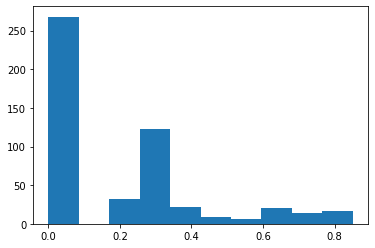

torch.Size([128, 128])


In [6]:
sample = dataset[2000]

plt.hist(np.array(sample['image'][:,:,0]).ravel())
plt.show()

print(sample['label'].shape)

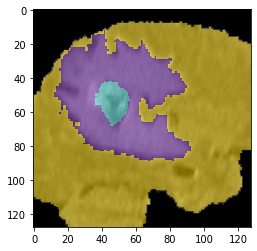

Zero Percent:  0.1988677978515625


In [7]:
for i in range(1):
    sample = dataset[2000]
    
    colors = ['none','gold', 'indigo', 'lightseagreen']
    cmap = matplotlib.colors.ListedColormap(colors)
    plt.imshow(np.array(sample['image'])[0, :,:].T, cmap='gray')
    plt.imshow(np.array(sample['label']).T, alpha=0.5, cmap=cmap)
    plt.show()

    print("Zero Percent: ", np.count_nonzero(np.array(sample['image']) == 0)/np.array(sample['image']).size)

In [8]:
sample['label'].sum()

tensor(17829)

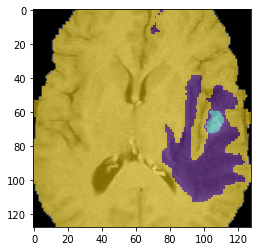

Zero Percent:  0.0968017578125


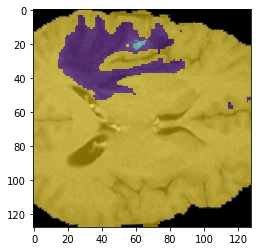

Zero Percent:  0.0977935791015625


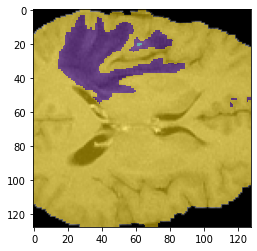

Zero Percent:  0.097747802734375


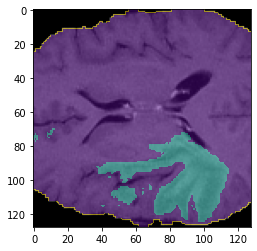

Zero Percent:  0.098846435546875


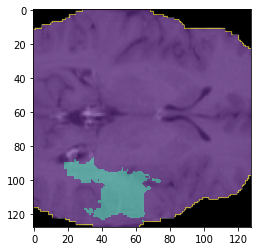

Zero Percent:  0.10809326171875


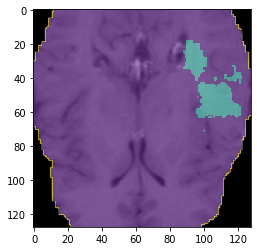

Zero Percent:  0.10614013671875


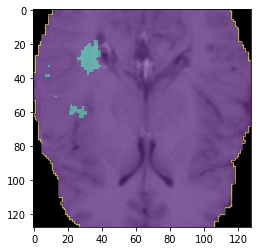

Zero Percent:  0.10345458984375


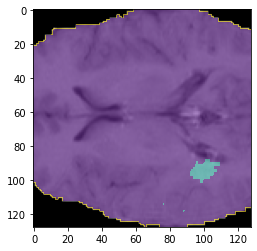

Zero Percent:  0.1025390625


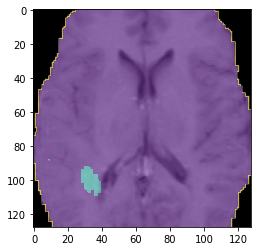

Zero Percent:  0.099609375


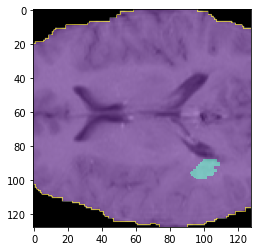

Zero Percent:  0.09906005859375


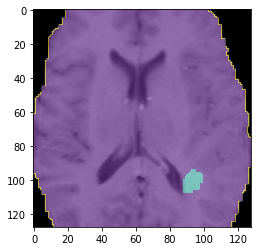

Zero Percent:  0.09771728515625


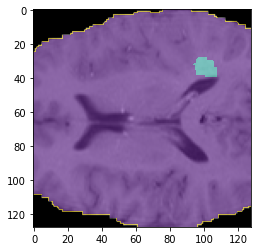

Zero Percent:  0.0977783203125


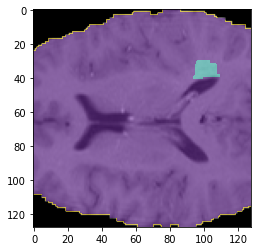

Zero Percent:  0.09954833984375


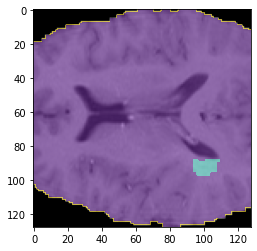

Zero Percent:  0.09967041015625


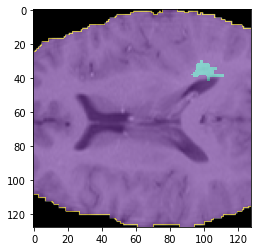

Zero Percent:  0.10040283203125


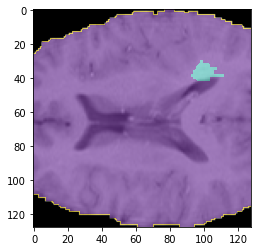

Zero Percent:  0.10089111328125


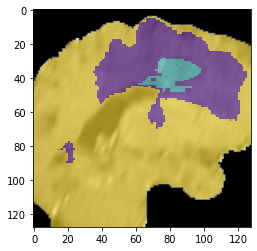

Zero Percent:  0.2193603515625


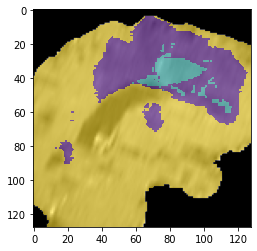

Zero Percent:  0.22015380859375


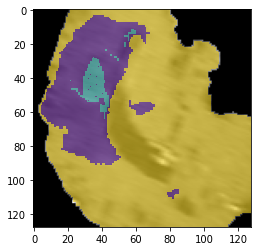

Zero Percent:  0.219482421875


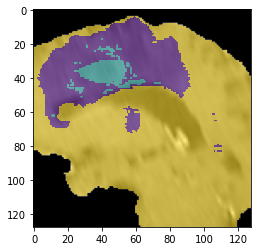

Zero Percent:  0.2220458984375


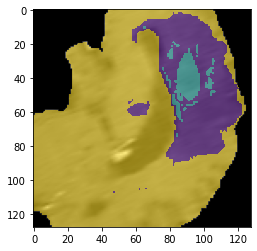

Zero Percent:  0.21966552734375


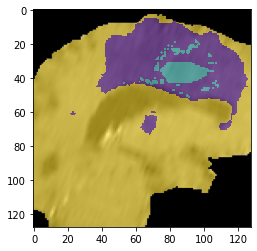

Zero Percent:  0.21759033203125


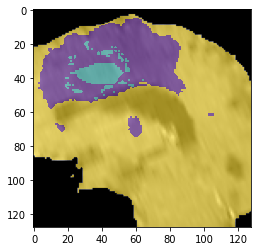

Zero Percent:  0.2222900390625


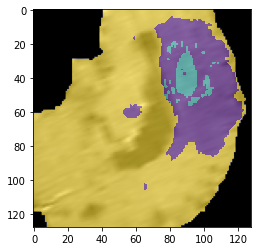

Zero Percent:  0.22052001953125


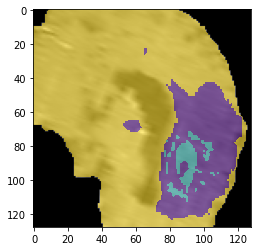

Zero Percent:  0.217041015625


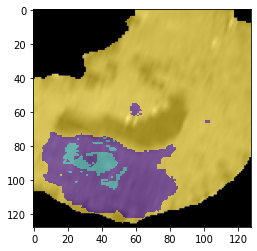

Zero Percent:  0.21514892578125


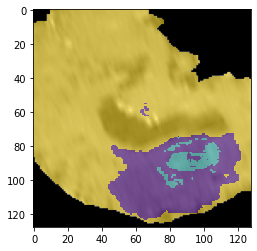

Zero Percent:  0.2137451171875


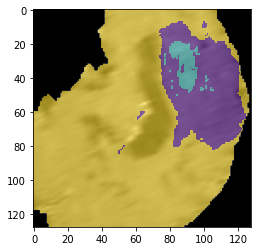

Zero Percent:  0.21112060546875


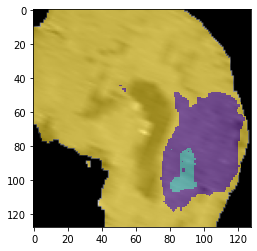

Zero Percent:  0.2120361328125


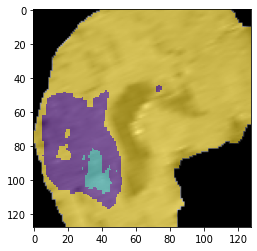

Zero Percent:  0.2080078125


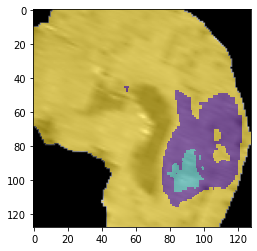

Zero Percent:  0.207275390625


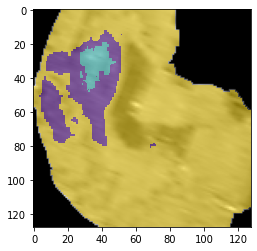

Zero Percent:  0.2032470703125


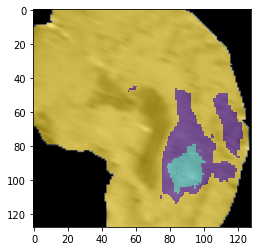

Zero Percent:  0.2091064453125


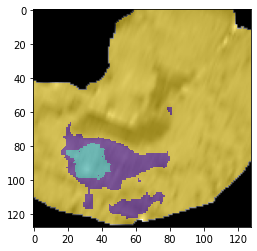

Zero Percent:  0.209716796875


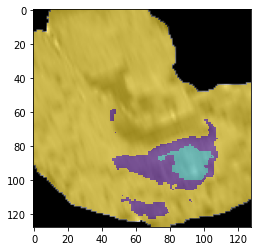

Zero Percent:  0.20745849609375


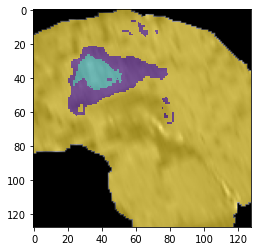

Zero Percent:  0.2086181640625


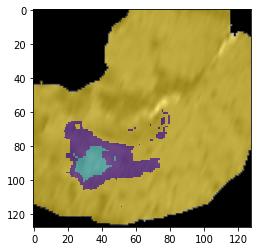

Zero Percent:  0.21136474609375


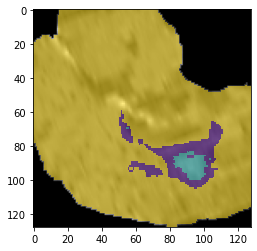

Zero Percent:  0.21038818359375


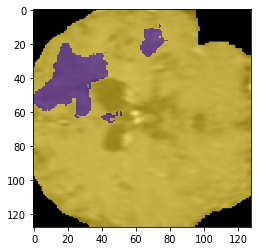

Zero Percent:  0.11517333984375


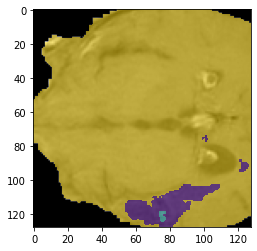

Zero Percent:  0.12933349609375


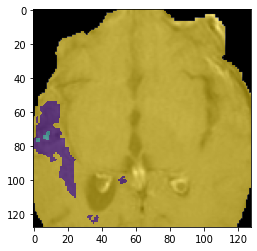

Zero Percent:  0.11871337890625


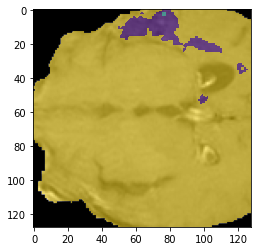

Zero Percent:  0.11407470703125


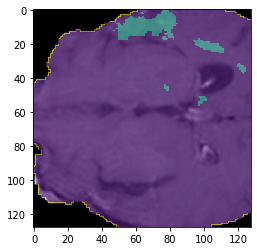

Zero Percent:  0.102783203125


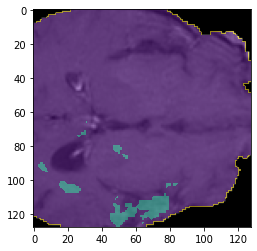

Zero Percent:  0.09783935546875


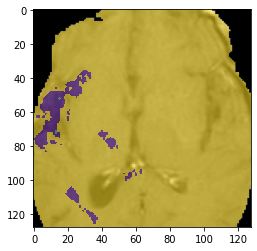

Zero Percent:  0.089599609375


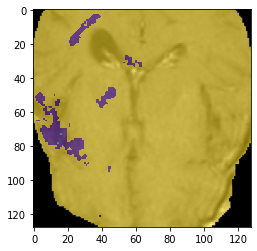

Zero Percent:  0.08477783203125


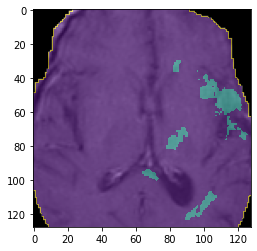

Zero Percent:  0.08062744140625


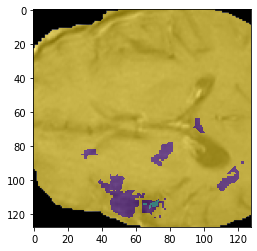

Zero Percent:  0.07867431640625


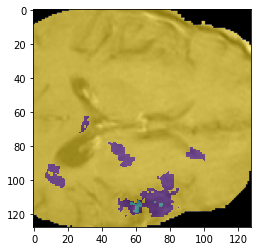

Zero Percent:  0.07537841796875


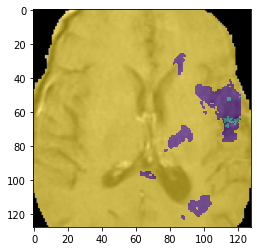

Zero Percent:  0.073486328125


In [9]:
for i in range(500,550):
    sample = dataset[i]
    
    colors = ['none','gold', 'indigo', 'lightseagreen']
    cmap = matplotlib.colors.ListedColormap(colors)
    plt.imshow(np.array(sample['image'])[2,:,:].T, cmap='gray')
    plt.imshow(np.array(sample['label']).T, alpha=0.5, cmap=cmap)
    plt.show()

    print("Zero Percent: ", np.count_nonzero(np.array(sample['image']) == 0)/np.array(sample['image']).size)

In [10]:
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=0)

0 torch.Size([4, 4, 128, 128]) torch.Size([4, 128, 128])


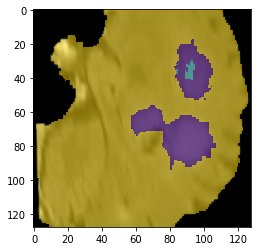

In [11]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())

    if i_batch == 0:
        colors = ['none','gold', 'indigo', 'lightseagreen']
        cmap = matplotlib.colors.ListedColormap(colors)
        plt.imshow(sample_batched['image'][i_batch//8, 0, :, :].T, cmap='gray')
        plt.imshow(sample_batched['label'][i_batch//8, :, :].T, alpha=0.5, cmap=cmap)
        #plt.show()
        break

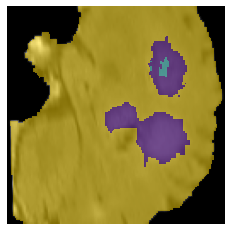

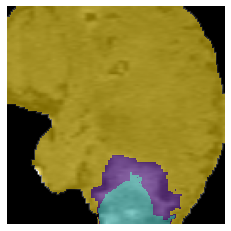

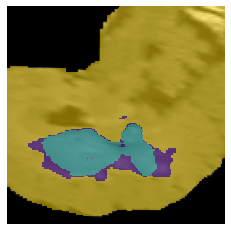

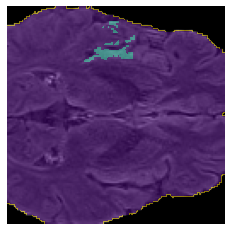

In [12]:
for z in range(sample_batched['image'].shape[0]):
    colors = ['none','gold', 'indigo', 'lightseagreen']
    cmap = matplotlib.colors.ListedColormap(colors)
        
    plt.imshow(sample_batched['image'][z, 0,:,:].T, cmap='gray')
    plt.imshow(sample_batched['label'][z,:,:].T, alpha=0.5, cmap=cmap)
    plt.axis('off')
    plt.show()

## Model Building

## CAPSULE LAYER

In [233]:
class CapsuleLayer(nn.Module):
    def __init__(self, num_child_capsules, num_parent_capsules, 
                 in_channels, out_channels, 
                 kernel_size=5, stride=1, 
                 num_route_iterations=3):
        super(CapsuleLayer, self).__init__()
        
        self.num_child_capsules = num_child_capsules
        self.num_parent_capsules = num_parent_capsules
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.num_route_iterations = num_route_iterations
        
        # W in the paper
        self.trans_matrix = nn.Parameter(torch.randn(num_child_capsules, num_parent_capsules, in_channels, out_channels))
        
        # b_ij in the paper
#         self.b_matrix = torch.zeros()
        
        self.capsules = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels*num_parent_capsules, kernel_size=kernel_size, stride=stride, padding=2) for _ in
                 range(num_child_capsules)])
        
    def squash(self, pred_tensor):
        
        norm = (pred_tensor ** 2).sum(-1, keepdim=True)
        
        numerator =  norm * (pred_tensor)
        denominator = (1 + norm) * torch.sqrt(norm)
        
        squashed_tensor = numerator / denominator
        
        return squashed_tensor
    
    def dynamic_routing(self, u_hat, b_matrix, num_iterations):
        
#         u_hat = np.matmul(u, self.trans_matrix)
        
        c_matrix = nn.Softmax(dim=-1)(b_matrix)
        
#         print("C matrix ",c_matrix.shape)
#         print("u_hat",u_hat.shape)
        
        s_vector = (c_matrix * u_hat).sum(dim=0, keepdim=True)
        
#         print(s_vector.shape)
        
        v_vector = self.squash(s_vector)
        
#         print(v_vector.shape)
        
        for i in range(num_iterations):
            agreement = (u_hat * v_vector).sum(dim=0)
            
            b_matrix += agreement
        
        return v_vector
    
    def forward(self, u, num_iter=3):
        # u (batch, # dimensions of input capsule (H, W), # input capsules, # Z/Atoms/Filters)
        
        u_hat = list()
        for num_child_caps in range(self.num_child_capsules):
            b, h, w, o_p = u[:,:,:, num_child_caps, :].shape
            u_hat_j = self.capsules[num_child_caps](u[:,:,:, num_child_caps, :].permute(0,3,1,2))
#             print("u_hat_j", u_hat_j.shape)
            b, o_p, h_1, w_1 = u_hat_j.shape
            # u_hat_j shape -> (batch, # dimensions of output capsule (H', W'), # out_channels * # num_parent_capsules)
            u_hat_j = u_hat_j.reshape(b, self.out_channels, h_1, w_1, self.num_parent_capsules,1)
            # u_hat_j shape -> (batch, # dimensions of output capsule (H', W'), # out_channels, # num_parent_capsules)
            u_hat.append(u_hat_j)
#             print(u_hat_j.shape)
        
#         print(len(u_hat))
        
        u_hat = torch.cat(u_hat, dim=-1)
        # u_hat shape -> (batch, # dimensions of output capsule (H', W'), # out_channels, # num_parent_capsules, # num input/child capsules)
#         print("Uhat ",u_hat.shape)
#         b_matrix = torch.zeros(b, h_1, w_1, self.num_child_capsules, self.num_parent_capsules)
        
        u_hat = u_hat.permute(5,0,1,2,3,4)
        # u_hat shape -> (# num input/child capsules, batch, # dimensions of output capsule (H', W'), # out_channels, # num_parent_capsules)
#         print("Uhat ",u_hat.shape)
        b_matrix = torch.zeros(u_hat.shape)
#         print("bmatrix ",b_matrix.shape)
        v_output = self.dynamic_routing(u_hat, b_matrix, num_iter)
        
#         print(v_output.shape)
        
        _, b, oc, h, w, nc = v_output.shape
        
        v_output = v_output.reshape(b, h, w, nc, oc)
        
        # v (batch, # dimensions of output capsule, 1, # current/output capsules)
        
        return v_output

In [234]:
out = CapsuleLayer(num_child_capsules=4, num_parent_capsules=8, 
                 in_channels=16, out_channels=32)(torch.randn(2,128,128,4,16))

In [235]:
out2 = CapsuleLayer(num_child_capsules=8, num_parent_capsules=16, 
                 in_channels=32, out_channels=128)(out)

In [236]:
out2.shape

torch.Size([2, 128, 128, 16, 128])

# Depth of network = 4

In [237]:
class MRI_CapsNet(nn.Module):
    def __init__(self):
        super(MRI_CapsNet, self).__init__()
        self.conv = nn.Conv2d(4, 16, 3, stride=1, padding=1)
        self.caps1 = CapsuleLayer(num_child_capsules=1, num_parent_capsules=4, in_channels=16, out_channels=32)
        self.caps2 = CapsuleLayer(num_child_capsules=4, num_parent_capsules=8, in_channels=32, out_channels=64)
        self.caps3 = CapsuleLayer(num_child_capsules=8, num_parent_capsules=1, in_channels=64, out_channels=128)
        
    def forward(self, inp_image):
        
        conv1 = self.conv(inp_image)
        b, c, h, w = conv1.shape
#         print(conv1.shape)
        conv1 = conv1.reshape(b, h, w, 1, c)
#         print(conv1.shape)
        caps1 = self.caps1(conv1)
        caps2 = self.caps2(caps1)
        caps3 = self.caps3(caps2)
        
        b, h, w, nc, oc = caps3.shape
        
        capsrs3 = caps3.view(b, nc*oc, h, w)
        
        final_conv = nn.Conv2d(nc*oc, 5, 1)(capsrs3)
     
        return final_conv, caps3      
        

In [238]:
model = MRI_CapsNet()

In [239]:
print(model)

MRI_CapsNet(
  (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (caps1): CapsuleLayer(
    (capsules): ModuleList(
      (0): Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (caps2): CapsuleLayer(
    (capsules): ModuleList(
      (0): Conv2d(32, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Conv2d(32, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (2): Conv2d(32, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): Conv2d(32, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (caps3): CapsuleLayer(
    (capsules): ModuleList(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): Conv2d(64, 128, kern

# Training

In [240]:
out_pred, caps_pred = model(torch.randn(8,4,128,128))

In [241]:
out_pred.shape

torch.Size([8, 5, 128, 128])

In [242]:
caps_pred.shape

torch.Size([8, 128, 128, 1, 128])

In [ ]:
data_name = pd.read_csv('image_name_info.csv')
device = "cpu"
nfold = KFold(n_splits=5, shuffle=True)
loss_weights = torch.FloatTensor([0.1, 0.1, 0.5, 0.5, 0.5]).to(device)
# seg_loss = nn.CrossEntropyLoss(weight=loss_weights).to(device)
seg_loss = nn.MSELoss().to(device)

OPTIMIZER = "adam"
LEARNING_RATE = 0.001
L2_WEIGHT_DECAY = 0
EPOCHS = 1
for fold, (train_ids, test_ids) in enumerate(nfold.split(data_name)):
#     log_dict = dict()

    print("Fold: ", fold+1, "/", 5) #, train_ids.shape, test_ids.shape)

    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)

    trainloader = DataLoader(
                      dataset, 
                      batch_size=16, sampler=train_subsampler)

    testloader = DataLoader(
                      dataset,
                      batch_size=1, sampler=test_subsampler)

    model = MRI_CapsNet().to(device)
    print("Model: ", model)

    if OPTIMIZER == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_WEIGHT_DECAY) # weight decay is for L2 regularization
    elif OPTIMIZER == "adam":
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_WEIGHT_DECAY) # weight decay is for L2 regularization
    elif OPTIMIZER == "rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_WEIGHT_DECAY)

    step = 0
    for epoch in range(EPOCHS):

        print("Epoch: ",epoch+1,"/",EPOCHS)
        current_loss = 0.0
        for i, data in enumerate(trainloader, 0):
#             print(i)

            inputs, labels = data['image'], data['label']
            
            inputs = inputs.to(device)
            labels = labels.float().to(device)

#             print(inputs)
#             print(labels)

            # forward pass
            outputs, caps_outs = model(inputs.float())
            outputs = outputs.to(device)
            caps_outs = caps_outs.to(device)
            
            outputs = torch.argmax(F.log_softmax(outputs, dim=1), dim=1)
        
            # loss calculation
            loss = seg_loss(outputs.float(), labels.float())
            
            print("Loss: ", loss.item())

In [256]:
caps_outs.shape

torch.Size([16, 128, 128, 1, 128])

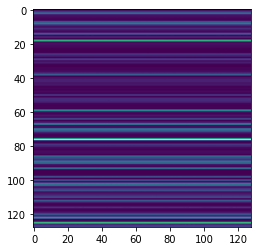

In [272]:
plt.imshow(nn.Sigmoid()(torch.norm(caps_outs, dim=[3,4]).detach())[5])

In [ ]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()
        self.weights = weight

    def forward(self, inputs, targets, eps=0.001):

        inputs = torch.argmax(F.log_softmax(inputs, dim=1), dim=1)
        
        inputs = F.one_hot(inputs, 5).float()
        targets = F.one_hot(targets.long(), 5).float()
        
        bat_sz = inputs.shape[0]
        ch_sz = inputs.shape[3]
        
        intersection = (inputs.view(bat_sz,-1,ch_sz) * targets.view(bat_sz,-1,ch_sz)).sum(1)
#         print("intersection: ",intersection)

        total = (inputs.view(bat_sz,-1,ch_sz) + targets.view(bat_sz,-1,ch_sz)).sum(1)
#         print(total)

        union = total - intersection
#         print(union)

        IoU = (intersection + eps)/(union + eps)
#         print(IoU)

        iouLoss = 1 - (IoU.mean(0) * self.weights).sum()/self.weights.sum()

        return iouLoss, IoU.mean(0)

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None):
        super(DiceLoss, self).__init__()
        self.weights = weight

    def forward(self, inputs, targets, eps=0.001):
        
        inputs = torch.argmax(F.log_softmax(inputs, dim=1), dim=1)
        
        inputs = F.one_hot(inputs, 5).float()
        targets = F.one_hot(targets, 5).float()
        
        bat_sz = inputs.shape[0]
        ch_sz = inputs.shape[3]

        intersection = (inputs.view(bat_sz,-1,ch_sz) * targets.view(bat_sz,-1,ch_sz)).sum(1)
#         print("intersection: ",intersection)

        total = (inputs.view(bat_sz,-1,ch_sz) + targets.view(bat_sz,-1,ch_sz)).sum(1)
#         print(total)

        dice = (2 * intersection + eps)/(total + eps)
#         print(IoU)

        diceLoss = 1 - (dice.mean(0) * self.weights).sum()/self.weights.sum()

        return diceLoss, dice.mean(0)